In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from main import create_rectangle_pulse, s11_s21_from_s2p_file, readout_signal_after_interaction_with_resonator

In [15]:
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['figure.figsize'] = (10, 8)

In [16]:
shift_f = 156 * 10 ** 3
f_state_1 = 7.2669 * 10 ** 9
N = 2 ** 23  # Number of sample points (power of 2 for FFT efficiency)
#resonator_frequency = 7.252534 * 10 ** 9  # Resonator frequency (Hz)
resonator_frequency = f_state_1 - shift_f / 2  # Resonator frequency (Hz)

<Figure size 1200x800 with 0 Axes>

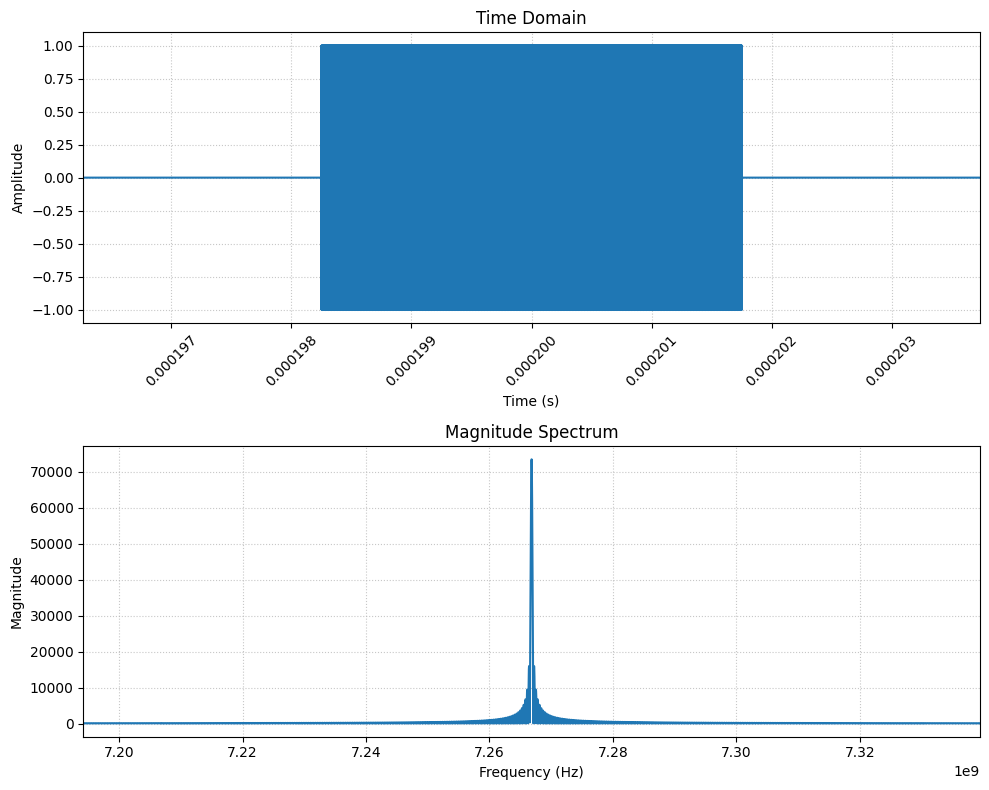

In [17]:
frequencies_pulse, pulse, pulse_t_signal, pulse_t_times, pulse_t_plot_edges = create_rectangle_pulse(
    f_resonator=resonator_frequency,
    samples_number=N,
    plot=True)

Interpolating S-parameters to 8388608 target frequencies.
Interpolation complete.


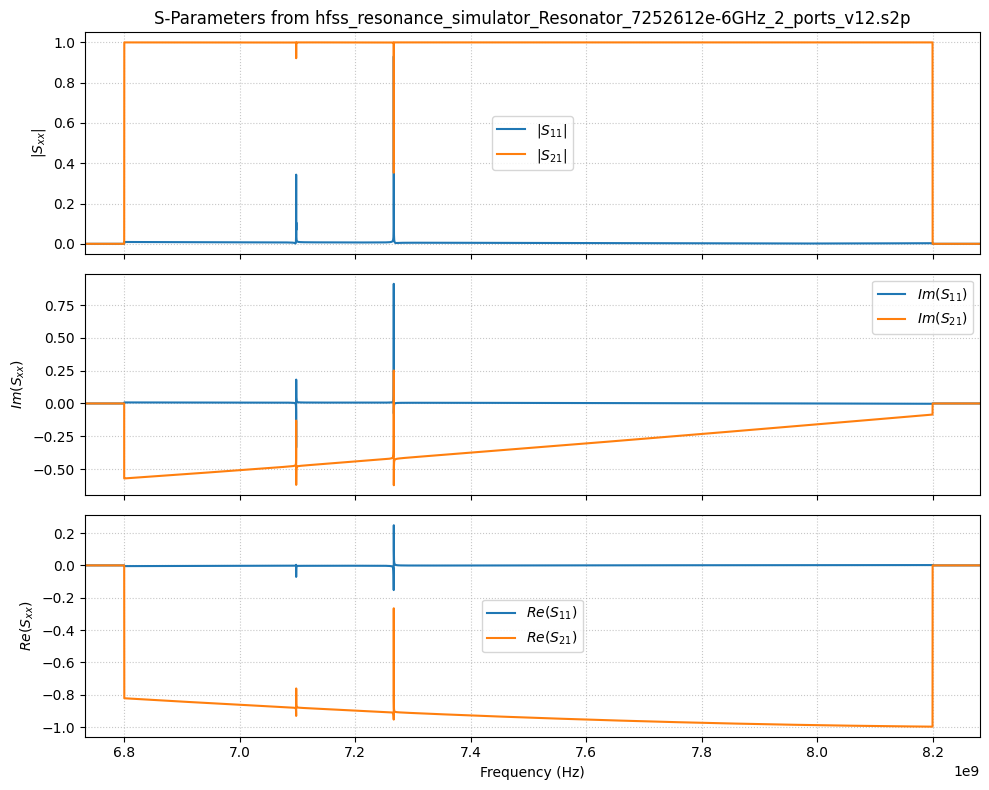

In [18]:
_, s11_state_1, s21_state_1 = s11_s21_from_s2p_file(
    simulation_results_filename='hfss_resonance_simulator_Resonator_7252612e-6GHz_2_ports_v12.s2p',
    target_pulse_frequencies=frequencies_pulse,
    plot=True,
)

In [19]:
# Create mock peak for |0> state
shift = int(shift_f / (frequencies_pulse[1] - frequencies_pulse[0]))

s11_state_0 = np.concatenate((s11_state_1[shift:], np.zeros(shift)))
s21_state_0 = np.concatenate((s21_state_1[shift:], np.zeros(shift)))


In [20]:
reflected_signal_state_1 = readout_signal_after_interaction_with_resonator(s=s11_state_1,
                                                                           pulse=pulse,
                                                                           frequencies=frequencies_pulse,
                                                                           plot=False)

transited_signal_state_1 = readout_signal_after_interaction_with_resonator(s=s21_state_1,
                                                                           pulse=pulse,
                                                                           frequencies=frequencies_pulse,
                                                                           plot=False)

reflected_signal_state_0 = readout_signal_after_interaction_with_resonator(s=s11_state_0,
                                                                           pulse=pulse,
                                                                           frequencies=frequencies_pulse,
                                                                           plot=False)

transited_signal_state_0 = readout_signal_after_interaction_with_resonator(s=s21_state_0,
                                                                           pulse=pulse,
                                                                           frequencies=frequencies_pulse,
                                                                           plot=False)

In [21]:
reflected_t_signal_state_0 = np.fft.ifft(np.fft.ifftshift(reflected_signal_state_0))
transited_t_signal_state_0 = np.fft.ifft(np.fft.ifftshift(transited_signal_state_0))

reflected_t_signal_state_1 = np.fft.ifft(np.fft.ifftshift(reflected_signal_state_1))
transited_t_signal_state_1 = np.fft.ifft(np.fft.ifftshift(transited_signal_state_1))

initial_t_pulse_signal = np.fft.ifft(np.fft.ifftshift(pulse))

# Plot State 1
# fig, ax = plt.subplots(4, 1)
#
# ax[0].plot(pulse_t_times, reflected_t_signal_state_0, lw=0.3)
# ax[0].set_title('Reflected Signal State 1')
# ax[0].set_ylabel('Amplitude a.u. ')
# ax[0].set_xlim(pulse_t_plot_edges)
# ax[0].grid(True)
#
# ax[1].plot(pulse_t_times, transited_t_signal_state_0, lw=0.3)
# ax[1].set_title('Transited Signal State 1')
# ax[1].set_ylabel('Amplitude a.u. ')
# ax[1].set_xlim(pulse_t_plot_edges)
# ax[1].grid(True)
#
# ax[2].plot(pulse_t_times, reflected_t_signal_state_0 + transited_t_signal_state_0, lw=0.3)
# ax[2].set_title('R+T Signal State 1')
# ax[2].set_ylabel('Amplitude a.u. ')
# ax[2].set_xlim(pulse_t_plot_edges)
# ax[2].grid(True)
#
# ax[3].plot(pulse_t_times, initial_t_pulse_signal, lw=0.3)
# ax[3].set_title('Initial Signal State 1')
# ax[3].set_ylabel('Amplitude a.u. ')
# ax[3].set_xlim(pulse_t_plot_edges)
# ax[3].grid(True)
#
# plt.tight_layout()
# plt.show()

In [22]:
def IQ_projection_homodyne_demodulation(pulse_t_signal: np.ndarray, transited_t_signal: np.ndarray):
    pulse_start = np.argmax(pulse_t_signal > 0)
    pulse_end = np.argmax(pulse_t_signal[pulse_start:] == 0) + pulse_start

    I = []
    Q = []

    for _ in tqdm(range(50)):
        noise = np.random.normal(0, 1, size=len(transited_t_signal))*3.5*10**(-4)
        s = transited_t_signal + noise
        s_I = s / 2
        s_Q = s / 2

        A_lo = 1
        y_I = A_lo / 2 * np.cos(resonator_frequency * pulse_t_times)
        y_Q = -A_lo / 2 * np.sin(resonator_frequency * pulse_t_times)

        dt = pulse_t_times[1] - pulse_t_times[0]

        I_pre_integration = s_I * y_I * dt
        Q_pre_integration = s_Q * y_Q * dt

        T = (pulse_end - pulse_start) * dt
        I.append(1 / T * sum(I_pre_integration[pulse_start:pulse_end]))
        Q.append(1 / T * sum(Q_pre_integration[pulse_start:pulse_end]))

    return I, Q

100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


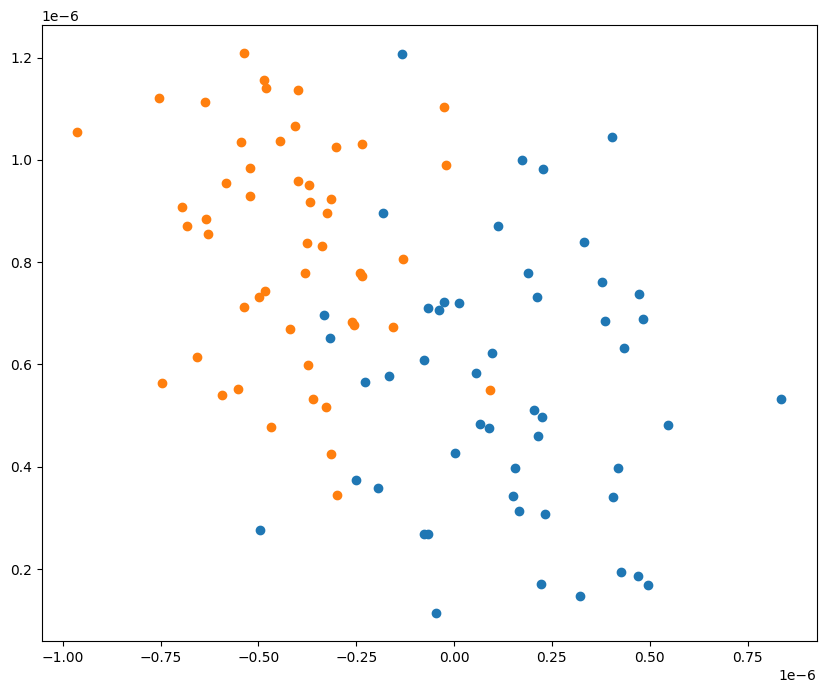

In [23]:
I_state_0, Q_state_0 = IQ_projection_homodyne_demodulation(pulse_t_signal, transited_t_signal_state_0)
I_state_1, Q_state_1 = IQ_projection_homodyne_demodulation(pulse_t_signal, transited_t_signal_state_1)
plt.scatter(I_state_0, Q_state_0)
plt.scatter(I_state_1, Q_state_1)


In [24]:
# pulse_start = np.argmax(pulse_t_signal > 0)
# pulse_end = np.argmax(pulse_t_signal[pulse_start:] == 0) + pulse_start
#
# s = transited_t_signal_state_0
# s_I = s / 2
# s_Q = s / 2
#
# A_lo = 1
# y_I = A_lo / 2 * np.cos(resonator_frequency * pulse_t_times)
# y_Q = -A_lo / 2 * np.sin(resonator_frequency * pulse_t_times)
#
# dt = pulse_t_times[1] - pulse_t_times[0]
#
# I_pre_integration = s_I * y_I * dt
# Q_pre_integration = s_Q * y_Q * dt
#
# I = []
# Q = []
# mid_point = int((pulse_start + pulse_end) / 2)
# for i in tqdm(range(mid_point - 1000, mid_point + 1000, 20)):
#     T = i * dt
#     I.append(1 / T * sum(I_pre_integration[:i]))
#     Q.append(1 / T * sum(Q_pre_integration[:i]))


In [25]:
# pulse_start = np.argmax(pulse_t_signal > 0)
# pulse_end = np.argmax(pulse_t_signal[pulse_start:] == 0) + pulse_start
#
# I = []
# Q = []
#
# for _ in range(100):
#     noise = np.random.normal(0, 1, size=len(reflected_t_signal))
#     s = reflected_t_signal + noise
#     s_I = s / 2
#     s_Q = s / 2
#
#     A_lo = 1
#     y_I = A_lo / 2 * np.cos(resonator_frequency * pulse_t_times)
#     y_Q = -A_lo / 2 * np.sin(resonator_frequency * pulse_t_times)
#
#     dt = pulse_t_times[1] - pulse_t_times[0]
#
#     I_pre_integration = s_I * y_I * dt
#     Q_pre_integration = s_Q * y_Q * dt
#
#     mid_point = int((pulse_start + pulse_end) / 2)
#     T = (pulse_end - pulse_start) * dt
#     I.append(1 / T * sum(I_pre_integration[pulse_start:pulse_end]))
#     Q.append(1 / T * sum(Q_pre_integration[pulse_start:pulse_end]))
#
# plt.scatter(I, Q)

In [26]:
# plt.plot(I, Q, alpha=0.5)
#
# plt.scatter(I[:10], Q[:10], c="r")
# plt.scatter(I[10:20], Q[10:20], c="b")
# plt.scatter(I[-10:], Q[-10:], c="black")
# plt.xlabel("I")
# plt.ylabel("Q")
# plt.show()